In [1]:
from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #E64626; color: #ffffff; font-size: 40px;} .text_cell_render h3 { padding: 10px 12px; background-color: #0148A4; position: static; color: #ffffff; font-size: 20px;} h4:before{ 
    content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #FFB800; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
''')

# Torchvision - Intel Image Classification Dataset

In [2]:
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision.models as models
import torch
from timeit import default_timer as timer
import numpy as np
from tqdm import tqdm
import os
from torch import nn
from PIL import Image
import seaborn as sns
from torchvision import transforms as T, datasets
import matplotlib.pyplot as plt
from pathlib import Path
torch.manual_seed(1984) #Set seed to ensure reproducability

In [3]:
#Setting Directory Path for the Dataset
train_dir = 'seg_train/seg_train'
test_dir = 'seg_test/seg_test/'
pred_dir = 'seg_pred/seg_pred'

#Image normalisation variables. Mean and STD taken from ImageNet Statistics, and image_size resized to 150x150 pixels (standard practice)
mean, std_tr, std_te, image_size, crop, horizontal_flip= [0.425, 0.415, 0.405], [0.205, 0.205, 0.205], [0.255, 0.245, 0.235], 150, 150,  0.5

#Recording data transformations processes for later, on-the-fly transformations
transformations_tr = T.Compose([T.Resize((image_size, image_size)), T.RandomHorizontalFlip(p=horizontal_flip), T.ColorJitter(0.3,0.4,0.4,0.2), T.ToTensor(), T.Normalize(mean = mean, std = std_tr)])
transformations_te = T.Compose([T.Resize((image_size, image_size)), T.ToTensor(), T.Normalize(mean = mean, std = std_te)])

#Distribute image data into 3 sets
training_set, testing_set = datasets.ImageFolder(train_dir, transform= transformations_tr), datasets.ImageFolder(test_dir, transform= transformations_te)

#Check length of each sets to see if its appropriately distributed
print(len(training_set)); print(len(testing_set))

14034
3000


In [4]:
val_size = 0.15  # Percentage for validation split

# Get indices for the dataset
indx = list(range(len(training_set)))
np.random.shuffle(indx)

# Create samplers directly from the shuffled indices
num_train = len(training_set)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(val_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

#Create Dataloader sets for train, test, and validation
train_dl, test_dl, val_dl = DataLoader(dataset= training_set, batch_size= 50 ,num_workers=2, sampler=train_sampler), DataLoader(dataset = testing_set, batch_size= 32, num_workers=2, shuffle = False), DataLoader(dataset= training_set ,batch_size= 100 ,num_workers=3, sampler=valid_sampler )

In [5]:
# Load a pre-trained Wide ResNet-50-2 model:
model = models.wide_resnet50_2(pretrained=True)

# Freeze all model parameters except for the final layer:
for param in model.parameters():
    param.requires_grad = False  

# Get the number of input features for the original last layer:
num_feature = model.fc.in_features

# Replace the final classification layer to match your dataset:
model.fc = nn.Linear(num_feature, 6) 

# View the structure of the new final layer (optional):
print(model.fc)

# Move the model to the GPU for accelerated training:
model.to('cuda') 

C:\Users\dungh\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dungh\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=2048, out_features=6, bias=True)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [6]:
# Define the loss function:
criterion = torch.nn.CrossEntropyLoss()  # Used for classification tasks

# Create the optimizer:
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01) 

milestones = [4,6]
gamma = 0.055

schedul_learning = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

device = 'cuda'

In [7]:
def predict(image):
    """Predicts the class of a single image.

    Args:
        img: A PIL Image object.

    Returns:
        The predicted class index as an integer.
    """
    tf_img = transformations_te(image)
    img_cuda = tf_img.unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(img_cuda)
    
    i = prediction.data.cpu().numpy().argmax()
    return i

def one_epoch(model, data_loader, device, criterion, optimizer):
    """Performs a single training epoch.""" 
    model.train()  # Ensure the model is in training mode

    tr_loss = 0

    for batch, (images, classes) in enumerate(data_loader):
        images, classes = images.to(device), classes.to(device)

        optimizer.zero_grad() 
        
        class_pred = model(images)  

        loss = criterion(class_pred, classes) 

        loss.backward()
        optimizer.step()

        tr_loss += loss.item()*images.size(0)

    return tr_loss

def eval_epoch(model, data_loader, device, criterion):
    """Performs a single evaluation epoch."""
    model.eval()  # Set the model to evaluation mode

    val_loss = 0
    
    for batch, (image, classes) in enumerate(data_loader):  
        image, classes = image.to(device), classes.to(device)

        class_pred = model(image)
        loss = criterion(class_pred, classes)

        val_loss += loss.item()*image.size(0)

    return val_loss

def announce(status, loss, epoch):
    print(f"Epoch {epoch} - {status} process completed.")
    print(f"Epoch {epoch} - {status} loss          -> {loss:.3f}")


In [8]:
st_time = timer()
epochs = 10
device = 'cuda'
valid_loss_min = np.Inf

training_losses = []
validation_losses = []

for epoch in tqdm(range(1,epochs+1)):
    print(f'Iteration {epoch}')

    tr_loss = one_epoch(model, train_dl, device, criterion, optimizer)
    tr_loss =  tr_loss/len(train_dl.sampler)
    announce('Training', tr_loss, epoch)

    val_loss = eval_epoch(model, val_dl, device, criterion)   
    val_loss = val_loss/len(val_dl.sampler)
    announce('Validation', val_loss, epoch)

    training_losses.append(tr_loss)
    validation_losses.append(val_loss)
    
    schedul_learning.step()
    end_time = timer()  
    
    if val_loss <= valid_loss_min:   
        print("Decrease Validation Loss {:.4f} : {:.4f} ".format(valid_loss_min, val_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = val_loss
        
    print('Learning Rate : {:.4f}'.format(optimizer.state_dict()['param_groups'][0]['lr']))
    print('\nTime : {:.2f}'.format(end_time - st_time))
    print('----------------------------------')

  0%|          | 0/10 [00:00<?, ?it/s]

Iteration 1
Epoch 1 - Training process completed.
Epoch 1 - Training loss          -> 0.905
Epoch 1 - Validation process completed.
Epoch 1 - Validation loss          -> 0.601
Decrease Validation Loss inf : 0.6009 


 10%|█         | 1/10 [01:24<12:38, 84.27s/it]

Learning Rate : 0.0100

Time : 83.89
----------------------------------
Iteration 2
Epoch 2 - Training process completed.
Epoch 2 - Training loss          -> 0.579
Epoch 2 - Validation process completed.
Epoch 2 - Validation loss          -> 0.513
Decrease Validation Loss 0.6009 : 0.5130 


 20%|██        | 2/10 [02:47<11:08, 83.59s/it]

Learning Rate : 0.0100

Time : 167.01
----------------------------------
Iteration 3
Epoch 3 - Training process completed.
Epoch 3 - Training loss          -> 0.508
Epoch 3 - Validation process completed.
Epoch 3 - Validation loss          -> 0.472
Decrease Validation Loss 0.5130 : 0.4715 


 30%|███       | 3/10 [04:10<09:44, 83.54s/it]

Learning Rate : 0.0100

Time : 250.49
----------------------------------
Iteration 4
Epoch 4 - Training process completed.
Epoch 4 - Training loss          -> 0.484
Epoch 4 - Validation process completed.
Epoch 4 - Validation loss          -> 0.449
Decrease Validation Loss 0.4715 : 0.4489 


 40%|████      | 4/10 [05:34<08:21, 83.61s/it]

Learning Rate : 0.0006

Time : 334.19
----------------------------------
Iteration 5
Epoch 5 - Training process completed.
Epoch 5 - Training loss          -> 0.463
Epoch 5 - Validation process completed.
Epoch 5 - Validation loss          -> 0.434
Decrease Validation Loss 0.4489 : 0.4342 


 50%|█████     | 5/10 [06:58<06:57, 83.59s/it]

Learning Rate : 0.0006

Time : 417.75
----------------------------------
Iteration 6
Epoch 6 - Training process completed.
Epoch 6 - Training loss          -> 0.462
Epoch 6 - Validation process completed.
Epoch 6 - Validation loss          -> 0.426
Decrease Validation Loss 0.4342 : 0.4263 


 60%|██████    | 6/10 [08:21<05:34, 83.57s/it]

Learning Rate : 0.0000

Time : 501.27
----------------------------------
Iteration 7
Epoch 7 - Training process completed.
Epoch 7 - Training loss          -> 0.456


 70%|███████   | 7/10 [09:44<04:10, 83.39s/it]

Epoch 7 - Validation process completed.
Epoch 7 - Validation loss          -> 0.427
Learning Rate : 0.0000

Time : 584.70
----------------------------------
Iteration 8
Epoch 8 - Training process completed.
Epoch 8 - Training loss          -> 0.450


 80%|████████  | 8/10 [11:07<02:46, 83.27s/it]

Epoch 8 - Validation process completed.
Epoch 8 - Validation loss          -> 0.438
Learning Rate : 0.0000

Time : 667.70
----------------------------------
Iteration 9
Epoch 9 - Training process completed.
Epoch 9 - Training loss          -> 0.450


 90%|█████████ | 9/10 [12:30<01:23, 83.15s/it]

Epoch 9 - Validation process completed.
Epoch 9 - Validation loss          -> 0.431
Learning Rate : 0.0000

Time : 750.60
----------------------------------
Iteration 10
Epoch 10 - Training process completed.
Epoch 10 - Training loss          -> 0.456


100%|██████████| 10/10 [13:53<00:00, 83.35s/it]

Epoch 10 - Validation process completed.
Epoch 10 - Validation loss          -> 0.441
Learning Rate : 0.0000

Time : 833.49
----------------------------------


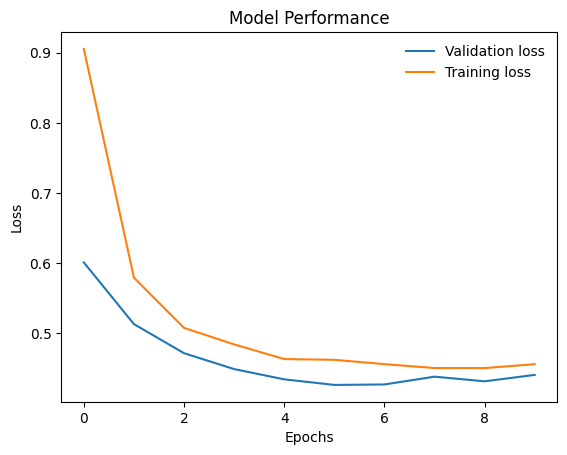

In [9]:
plt.plot(validation_losses, label='Validation loss')
plt.plot(training_losses, label='Training loss')
plt.title('Model Performance')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()

In [10]:
# Load model state dict
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

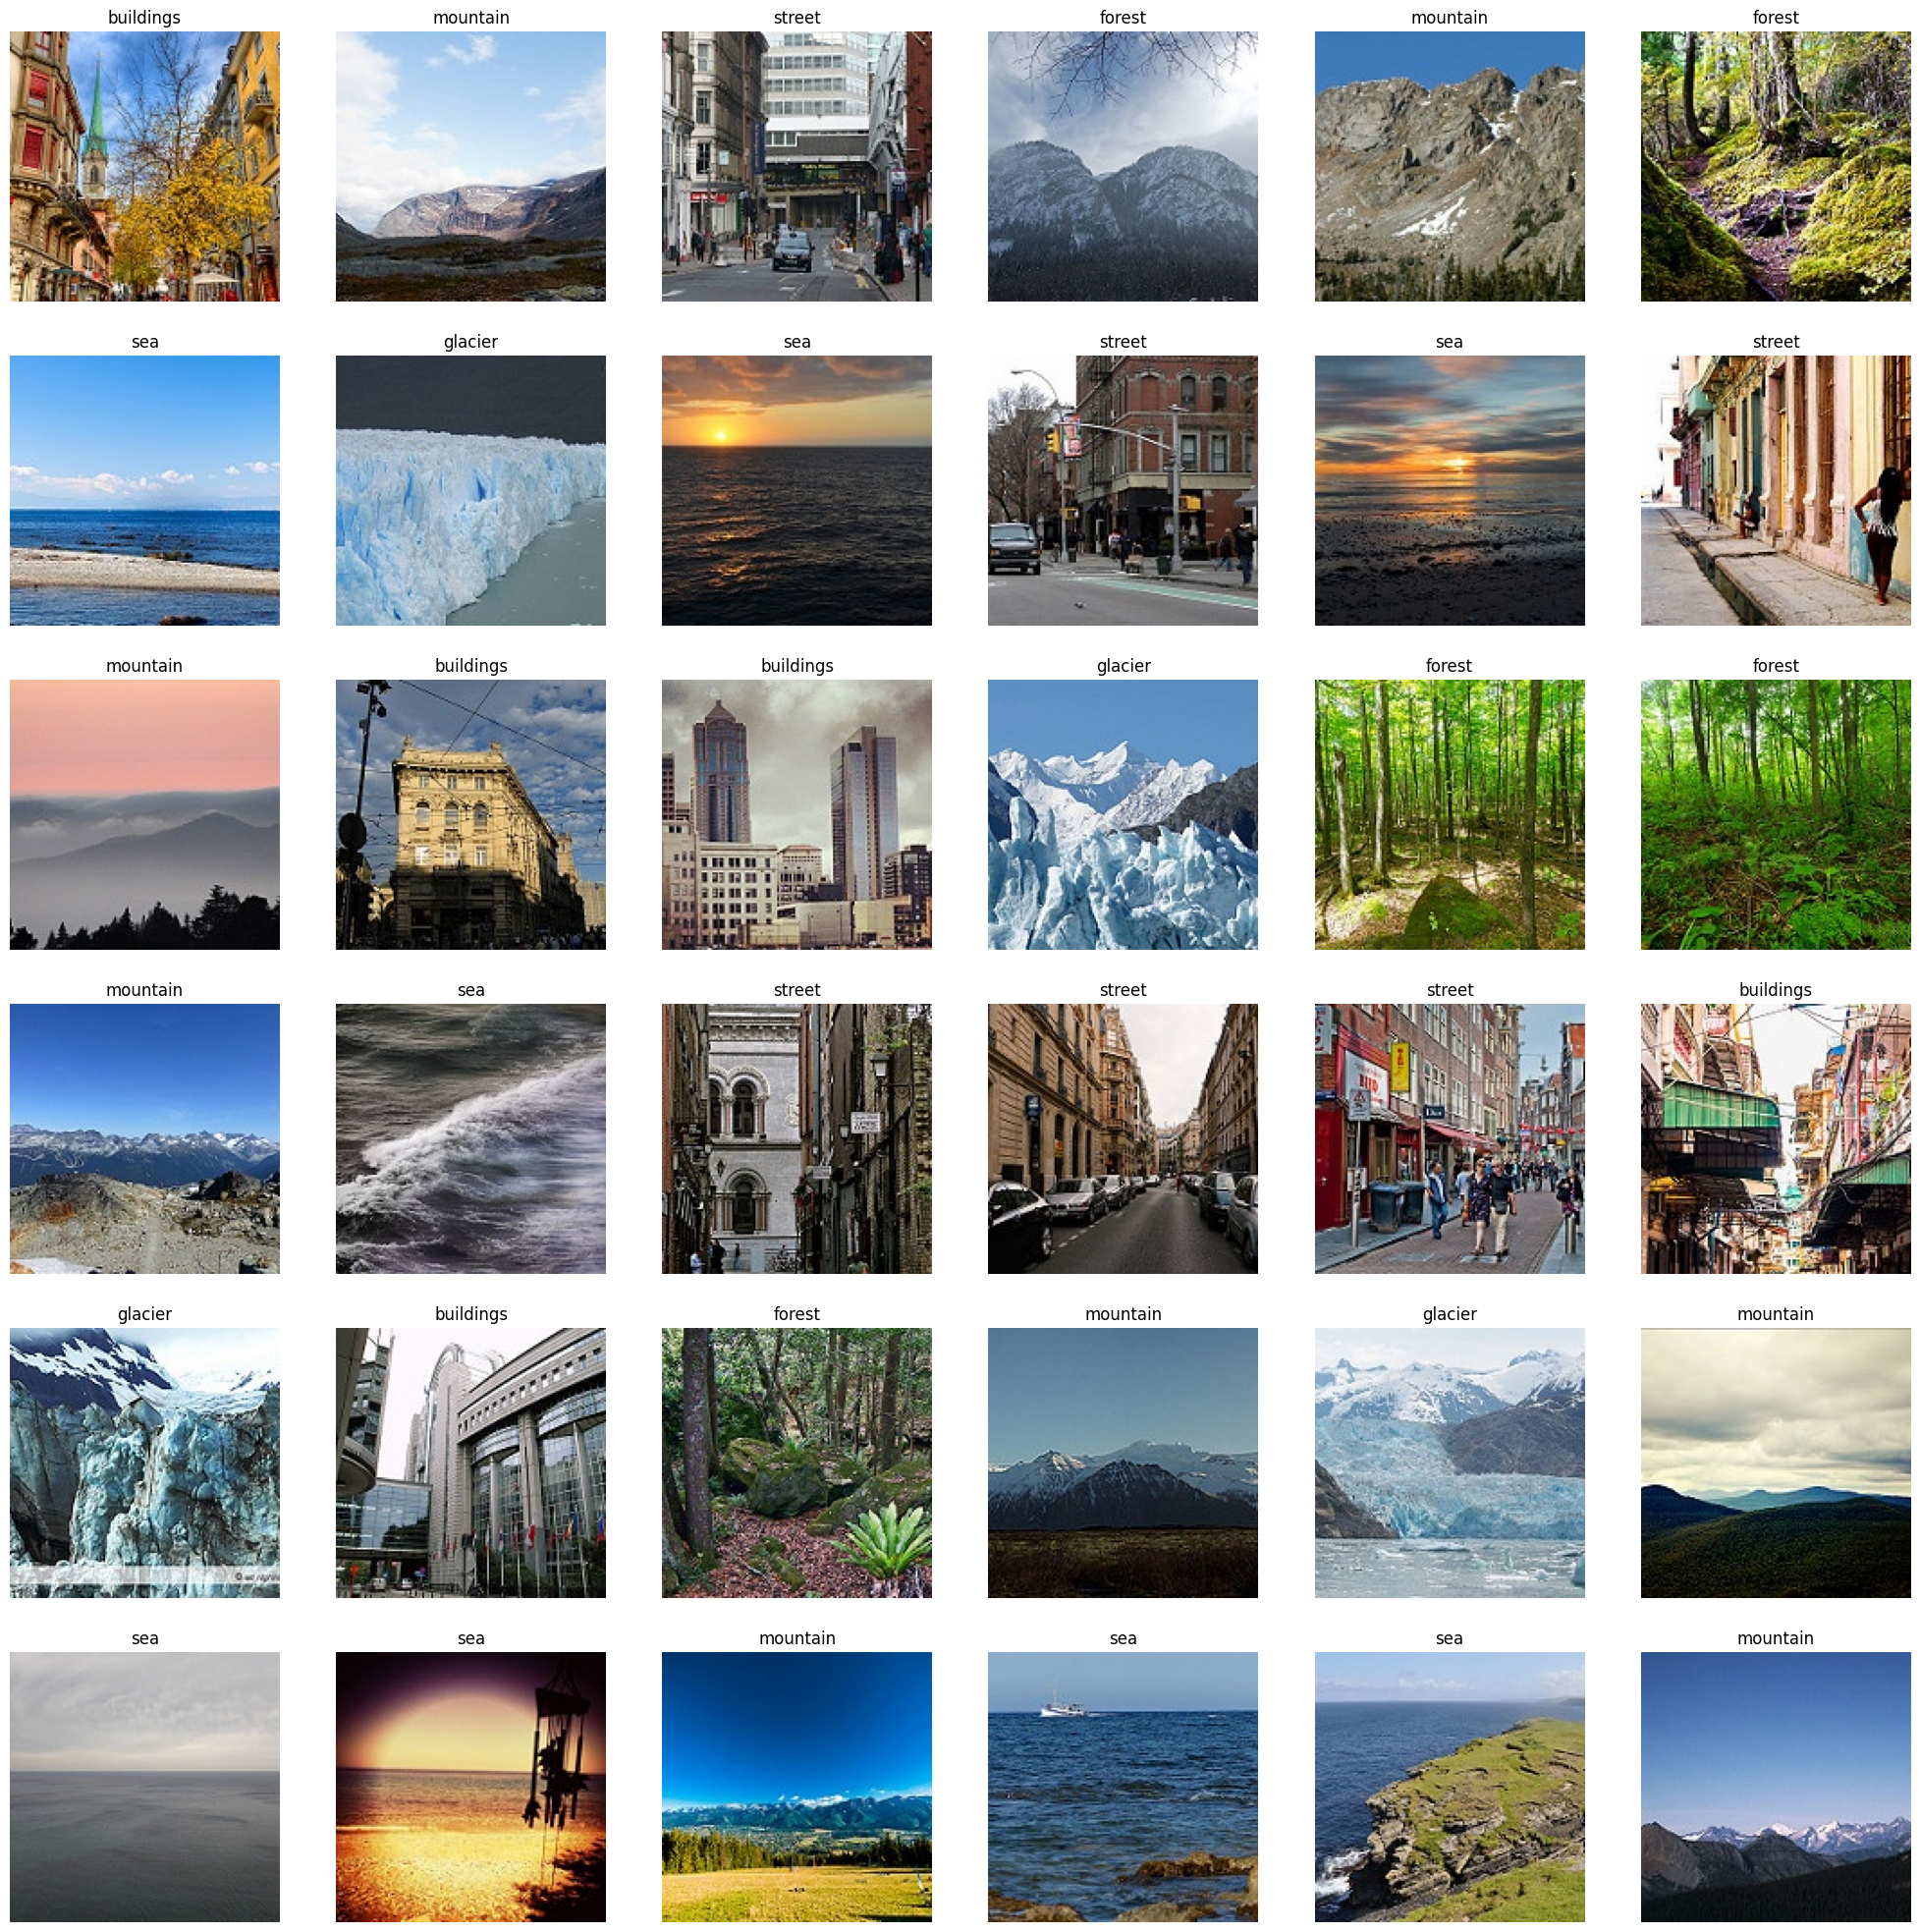

In [11]:
#Create list of image paths for prediction image files
pred_ls = [os.path.join(pred_dir, i) for i in os.listdir(pred_dir)]

#Find all classes in directory and make it a dictionary
classes = {i: j for i, j in enumerate(sorted(os.listdir(train_dir)))}

model.eval()


plt.figure(figsize=(25,25))
for i, img in enumerate(pred_ls):
    if i >=  36:
        break

    image = Image.open(img)
    j = predict(image)


    plt.subplot(6, 6, i+1)
    plt.title(classes[j])
    plt.axis('off')
    plt.imshow(image)

plt.show()